# PCA with Image Dataset CIFAR-10

### Load the data

In [2]:
import torch
import os
print("PyTorch version:", torch.__version__)
torch_path = os.path.dirname(torch.__file__)
print("PyTorch is installed in:", torch_path)

PyTorch version: 2.5.0+cpu
PyTorch is installed in: c:\Users\Nick\OneDrive\Documents\Projects\PCA_Capstone\STA6257_PCA\venv\lib\site-packages\torch


In [3]:
import sys
print("Python executable:", sys.executable)
print("Python version:", sys.version)

Python executable: c:\Users\Nick\OneDrive\Documents\Projects\PCA_Capstone\STA6257_PCA\venv\Scripts\python.exe
Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


verify that PyTorch is correctly set up to use the GPU by running:

In [ ]:
import torch
print(torch.cuda.is_available())

Check if GPU is available

In [4]:
if torch.cuda.is_available():
    print("GPU is available")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")

GPU is not available


Practical Implementation Scenarios:
PCA is commonly referred to as a practical technique for image compression and dimentionality reduction for classification tasks. While PCA does provide an improvement for traditional machine learning models like SVM, modern models such as CNNs have allowed for practical application, replacing the need to use PCA. CNNs are smaller modules, especially models such as Tiny Yolo which are on the order of 10 MB, nearly 1% the size of SVM models. This allows for these models to be deployed across smart devices in edge-computing applications. THe reduction in model size also results in much faster predictions in production.

The CIFAR-10 dataset consists of 5000 32x32 colour images in 10 classes. The dataset is normalized and divided into training, validation, and test sets.  

In [3]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

### Normalize

In [4]:
# Normalize the pixel values to range 0-1
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("Training images shape:", X_train.shape)
print("Test images shape:", X_test.shape)
print("Min and max pixel values:", X_test.min(), X_test.max())

Training images shape: (50000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)
Min and max pixel values: 0.0 1.0


### Split training data to create a validation set

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42)

### Principal Component Analysis

Flatten the images from 32x32 pixels with 3 color channels (n x 32x32x3 array) into a 2-D vector (n x 3072).  
PCA requires a 2-dimensional input (samples x features).

In [6]:
# Flatten the X data
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_validate_flat = X_validate.reshape((X_validate.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

print(X_train_flat.shape)
print(X_validate_flat.shape)
print(X_test_flat.shape)

(42500, 3072)
(7500, 3072)
(10000, 3072)


In [7]:
from sklearn.decomposition import PCA

# Initialize PCA and fit on the training data
pca = PCA(n_components=0.95)
pca.fit(X_train_flat)

# Transform both the training and testing data
X_train_pca = pca.transform(X_train_flat)
X_validate_pca = pca.transform(X_validate_flat)
X_test_pca = pca.transform(X_test_flat)

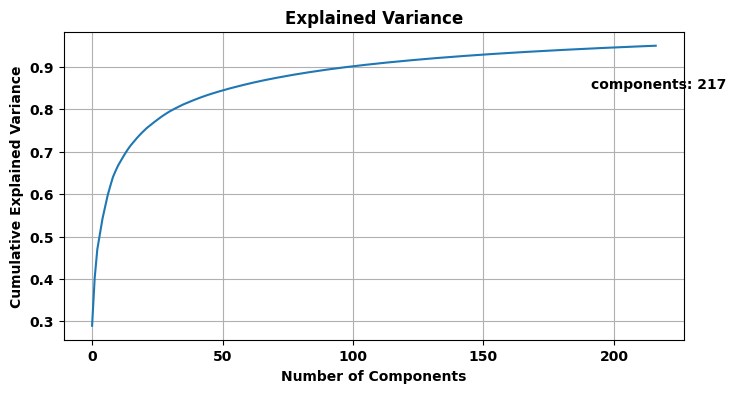

In [10]:
import matplotlib.pyplot as plt
import numpy as np

n_components = pca.n_components_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance
plt.figure(figsize=(8, 4))
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance')
plt.grid(True)

# Annotate the number of components used
plt.annotate(f'components: {n_components}', 
             xy=(n_components, cumulative_variance[n_components-1]),  # This places the annotation at the point where the number of components is reached
             xytext=(n_components, cumulative_variance[n_components-1] - 0.10),  # Adjust text position
             ha='center')  # Horizontal alignment

plt.show()

View photo quality

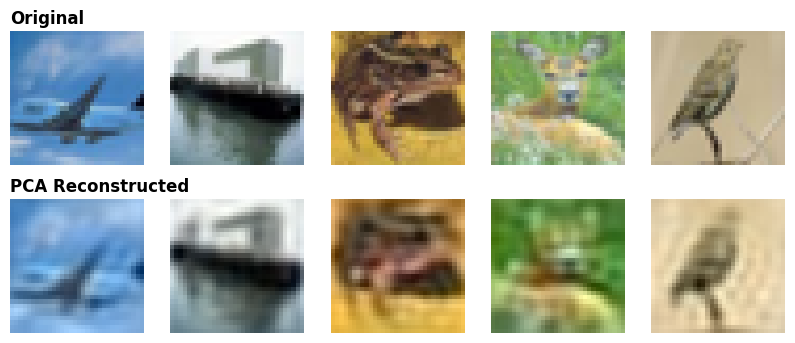

In [7]:
import matplotlib.pyplot as plt

def plot_images(original, reconstructed, n):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Plot original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.axis('off')
        if i == 0:
            ax.set_title("Original", loc='left')

        # Plot reconstructed images
        ax = plt.subplot(2, n, n + i + 1)
        norm_image = (reconstructed[i] - np.min(reconstructed[i])) / (np.max(reconstructed[i]) - np.min(reconstructed[i]))
        plt.imshow(norm_image)
        plt.axis('off')
        if i == 0:
            ax.set_title("PCA Reconstructed", loc='left')

    plt.show()

# reconstruct the PCA data into 32x32x3 arrays
X_train_reconstructed = pca.inverse_transform(X_train_pca)
X_train_reconstructed = X_train_reconstructed.reshape((X_train.shape[0], 32, 32, 3))
plot_images(X_train, X_train_reconstructed, n=5) # plot first 5 images


## SVM Model

Train

In [8]:
from sklearn.svm import SVC

model_svm = SVC(kernel='rbf', C=1.0, gamma='scale')
model_svm.fit(X_train_flat, y_train.flatten())

model_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
model_svm_pca.fit(X_train_pca, y_train.flatten())

SVC()

Save and load pickles

In [11]:
import pickle

def save_pickle(thing, path_pkl):
    with open(path_pkl, 'wb') as file:
        pickle.dump(thing, file)

def load_pickle(path_pkl):
    with open(path_pkl, 'rb') as file:
        pickle_file = pickle.load(file)
    return pickle_file

# model paths
model_svm_path = '../model/svm.pkl'
model_svm_pca_path = '../model/svm_PCA.pkl'

# Save models
# save_pickle(model_svm, model_svm_path)
# save_pickle(model_svm_pca, model_svm_pca_path)

# load models
model_svm = load_pickle(model_svm_path)
model_svm_pca = load_pickle(model_svm_pca_path)


Calculate Predictions

In [12]:
# validation set
svm_prediction_path = 'ml_result/validate/prediction_svm.pkl'
svm_pca_prediction_path = 'ml_result/validate/prediction_svm_pca.pkl'

# prediction on original data using SVM model
preds_svm = model_svm.predict(X_validate_flat)
save_pickle(preds_svm, svm_prediction_path)

# prediction on PCA data using SVM model
preds_svm_pca = model_svm_pca.predict(X_validate_pca)
save_pickle(preds_svm_pca, svm_pca_prediction_path)

In [13]:
# test set
svm_prediction_path = 'ml_result/test/prediction_svm.pkl'
svm_pca_prediction_path = 'ml_result/test/prediction_svm_pca.pkl'

# prediction on original data using SVM model
preds_svm = model_svm.predict(X_test_flat)
save_pickle(preds_svm, svm_prediction_path)

# prediction on PCA data using SVM model
preds_svm_pca = model_svm_pca.predict(X_test_pca)
save_pickle(preds_svm_pca, svm_pca_prediction_path)

Compare performance

In [23]:
import pickle
from sklearn.metrics import accuracy_score

# validation set
svm_prediction_path = 'ml_result/validate/prediction_svm.pkl'
svm_pca_prediction_path = 'ml_result/validate/prediction_svm_pca.pkl'
preds_svm = load_pickle(svm_prediction_path)
preds_svm_pca = load_pickle(svm_pca_prediction_path)

print("Accuracy on original data:", accuracy_score(y_validate, preds_svm))
print("Accuracy on PCA data:", accuracy_score(y_validate, preds_svm_pca))

Accuracy on original data: 0.5324
Accuracy on PCA data: 0.5312


In [24]:
import pickle
from sklearn.metrics import accuracy_score

# test set
svm_prediction_path = 'ml_result/test/prediction_svm.pkl'
svm_pca_prediction_path = 'ml_result/test/prediction_svm_pca.pkl'
preds_svm = load_pickle(svm_prediction_path)
preds_svm_pca = load_pickle(svm_pca_prediction_path)

print("Accuracy on original data:", round(accuracy_score(y_test, preds_svm), 3))
print("Accuracy on PCA data:", round(accuracy_score(y_test, preds_svm_pca), 3))

Accuracy on original data: 0.536
Accuracy on PCA data: 0.533


In [13]:
import time

# Evaluation function
def evaluate_prediction_time(model, X_test, n=100):
    X_test = X_test[:n]
    start_time = time.time()
    model.predict(X_test)
    total_time = time.time() - start_time
    print(f"Total time to predict {n} samples: {total_time:.2f} seconds")

# evaluate_prediction_time(model_svm, X_test_flat)
# evaluate_prediction_time(model_svm_pca, X_test_pca)

### Convolutional Neural Network (CNN)

9 layers such as Input, Conv2D, MaxPooling2D, Flatten, Dense . Every layer has its own hyper-parameters. Sequential operation

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_cnn = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, 3, padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, 3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.50),
    Dense(10, activation='softmax'),
])

# print(model_cnn.summary())

In [8]:
from tensorflow.keras import losses
from tensorflow.keras import optimizers

model_cnn.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),     
    optimizer = optimizers.Adam(learning_rate=3e-4),                               
    metrics =["accuracy"],                                                       
)

history_cnn = model_cnn.fit(X_train, y_train, 
                            batch_size = 64, 
                            epochs = 20,
                            verbose = 2,
                            validation_data=(X_validate, y_validate))

Epoch 1/20
665/665 - 27s - loss: 1.9822 - accuracy: 0.2665 - val_loss: 1.6899 - val_accuracy: 0.3984 - 27s/epoch - 41ms/step
Epoch 2/20
665/665 - 26s - loss: 1.6700 - accuracy: 0.3897 - val_loss: 1.5057 - val_accuracy: 0.4669 - 26s/epoch - 39ms/step
Epoch 3/20
665/665 - 25s - loss: 1.5483 - accuracy: 0.4420 - val_loss: 1.3868 - val_accuracy: 0.4979 - 25s/epoch - 38ms/step
Epoch 4/20
665/665 - 26s - loss: 1.4649 - accuracy: 0.4760 - val_loss: 1.2819 - val_accuracy: 0.5477 - 26s/epoch - 38ms/step
Epoch 5/20
665/665 - 25s - loss: 1.3889 - accuracy: 0.5048 - val_loss: 1.2009 - val_accuracy: 0.5752 - 25s/epoch - 38ms/step
Epoch 6/20
665/665 - 25s - loss: 1.3404 - accuracy: 0.5235 - val_loss: 1.2024 - val_accuracy: 0.5784 - 25s/epoch - 38ms/step
Epoch 7/20
665/665 - 25s - loss: 1.2893 - accuracy: 0.5451 - val_loss: 1.1017 - val_accuracy: 0.6136 - 25s/epoch - 38ms/step
Epoch 8/20
665/665 - 25s - loss: 1.2495 - accuracy: 0.5613 - val_loss: 1.0748 - val_accuracy: 0.6261 - 25s/epoch - 38ms/step


Investigate overfitting

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(model_history):
    '''
    Function to plot training and validation loss and accuracy.
    Returns the matplotlib figure object.
    '''
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plotting training and validation loss
    axs[0].plot(model_history.history['loss'], label='Training Loss')
    axs[0].plot(model_history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plotting training and validation accuracy
    axs[1].plot(model_history.history['accuracy'], label='Training Accuracy')
    axs[1].plot(model_history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.show()
    return fig  # Return the figure object for external use

# fig = plot_losses(history_cnn)
# fig.savefig('ml_result/validate/training_metrics.png')


In [9]:
model_cnn.save('../model/cnn_tf213.keras')
model_cnn.save('model/cnn_tf213.keras')

CNN with PCA

In [12]:
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

n_components = pca.n_components_

model_cnn_pca = Sequential([
    Input(shape=(n_components,)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax'),
])

# print(model_cnn.summary())

model_cnn_pca.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),     
    optimizer = optimizers.Adam(learning_rate=3e-4),                               
    metrics =["accuracy"],                                                       
)

history_cnn_pca = model_cnn_pca.fit(X_train_pca, y_train.flatten(), 
                            batch_size = 64, 
                            epochs = 20,
                            verbose = 2,
                            validation_data=(X_validate_pca, y_validate.flatten()))

Epoch 1/20
665/665 - 4s - loss: 2.3287 - accuracy: 0.1475 - val_loss: 2.1265 - val_accuracy: 0.2667 - 4s/epoch - 6ms/step
Epoch 2/20
665/665 - 2s - loss: 2.1216 - accuracy: 0.2165 - val_loss: 1.9643 - val_accuracy: 0.3220 - 2s/epoch - 4ms/step
Epoch 3/20
665/665 - 2s - loss: 2.0121 - accuracy: 0.2636 - val_loss: 1.8524 - val_accuracy: 0.3527 - 2s/epoch - 3ms/step
Epoch 4/20
665/665 - 2s - loss: 1.9289 - accuracy: 0.2999 - val_loss: 1.7827 - val_accuracy: 0.3773 - 2s/epoch - 4ms/step
Epoch 5/20
665/665 - 2s - loss: 1.8741 - accuracy: 0.3239 - val_loss: 1.7288 - val_accuracy: 0.3957 - 2s/epoch - 3ms/step
Epoch 6/20
665/665 - 2s - loss: 1.8257 - accuracy: 0.3436 - val_loss: 1.6957 - val_accuracy: 0.4127 - 2s/epoch - 4ms/step
Epoch 7/20
665/665 - 2s - loss: 1.7922 - accuracy: 0.3578 - val_loss: 1.6662 - val_accuracy: 0.4201 - 2s/epoch - 4ms/step
Epoch 8/20
665/665 - 2s - loss: 1.7571 - accuracy: 0.3761 - val_loss: 1.6361 - val_accuracy: 0.4305 - 2s/epoch - 3ms/step
Epoch 9/20
665/665 - 3s 

In [14]:
model_cnn_pca.save('../model/cnn_pca_tf213.keras')
model_cnn_pca.save('model/cnn_pca_tf213.keras')

### Evaluate accuracy & prediction time

Load the model

In [17]:
from tensorflow.keras.models import load_model

cnn_model_path = 'model/cnn_tf213.keras'
model_cnn = load_model(cnn_model_path)

In [18]:
# evaluate accuracy
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test)
print(f"Test Accuracy: {round(test_accuracy, 3)}")

# evaluate training time
evaluate_prediction_time(model_cnn, X_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.8539 - accuracy: 0.7053
Test Accuracy: 0.705
4/4 [==============================] - 0s 6ms/step
Total time to predict 100 samples: 0.16 seconds


CNNs are superior for image classification due to their ability to learn high-level features directly from data, adapt to complex patterns, and perform efficiently in real-time applications, including on IoT devices. While PCA + SVM might still be used for less complex or highly specific tasks where training data is limited or when computational simplicity is prioritized, CNNs are the standard for most current image processing tasks. This difference is crucial in educational settings, emphasizing the need to train students on technologies that they are most likely to use in industry, particularly in cutting-edge fields like machine learning and computer vision.

### Hyperparameter tuning

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential([
        Input(shape=(32, 32, 3)),
        Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=16),
               kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
               padding=hp.Choice('conv_1_padding', values=['same', 'valid']),
               activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.3, step=0.05)),

        Conv2D(filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=32),
               kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
               padding=hp.Choice('conv_2_padding', values=['same', 'valid']),
               activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.4, step=0.05)),

        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=64, max_value=128, step=32),
              activation='relu'),
        Dropout(rate=hp.Float('dropout_3', min_value=0.3, max_value=0.5, step=0.05)),
        Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,  # Increased number of trials for finer exploration
    executions_per_trial=1,
    directory='ml_result/hp_tuning',
    project_name='hparam_tuning'
)

tuner.search(x=X_train, y=y_train, epochs=10, validation_data=(X_validate, y_validate))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best model uses {best_hps.get('conv_1_filter')} filters in the first Conv layer,
a kernel size of {best_hps.get('conv_1_kernel')}, and {best_hps.get('dense_units')} units in the dense layer,
with a learning rate of {best_hps.get('learning_rate')}.
""")

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
# loss, accuracy = best_model.evaluate(X_test, y_test)
# print(f'Test accuracy: {accuracy}, Test loss: {loss}')


Trial 30 Complete [00h 05m 13s]
val_accuracy: 0.6797333359718323

Best val_accuracy So Far: 0.7330666780471802
Total elapsed time: 07h 32m 57s

The best model uses 64 filters in the first Conv layer,
a kernel size of 3, and 128 units in the dense layer,
with a learning rate of 0.001.



In [22]:
for hparam in best_hps.space:
    print(f"{hparam.name}: {best_hps.get(hparam.name)}")

conv_1_filter: 64
conv_1_kernel: 3
conv_2_filter: 128
conv_2_kernel: 3
dense_units: 128
learning_rate: 0.001
conv_1_padding: same
dropout_1: 0.15000000000000002
conv_2_padding: valid
dropout_2: 0.25
dropout_3: 0.3


Epoch 1/20
665/665 - 56s - loss: 0.6838 - accuracy: 0.7561 - val_loss: 0.7694 - val_accuracy: 0.7340 - 56s/epoch - 84ms/step
Epoch 2/20
665/665 - 55s - loss: 0.6743 - accuracy: 0.7596 - val_loss: 0.7660 - val_accuracy: 0.7355 - 55s/epoch - 83ms/step
Epoch 3/20
665/665 - 55s - loss: 0.6505 - accuracy: 0.7673 - val_loss: 0.7614 - val_accuracy: 0.7389 - 55s/epoch - 83ms/step
Epoch 4/20
665/665 - 58s - loss: 0.6347 - accuracy: 0.7730 - val_loss: 0.7773 - val_accuracy: 0.7335 - 58s/epoch - 87ms/step
Epoch 5/20
665/665 - 58s - loss: 0.6160 - accuracy: 0.7779 - val_loss: 0.7608 - val_accuracy: 0.7392 - 58s/epoch - 88ms/step
Epoch 6/20
665/665 - 55s - loss: 0.6013 - accuracy: 0.7841 - val_loss: 0.7682 - val_accuracy: 0.7384 - 55s/epoch - 83ms/step
Epoch 7/20
665/665 - 57s - loss: 0.5919 - accuracy: 0.7854 - val_loss: 0.7645 - val_accuracy: 0.7371 - 57s/epoch - 85ms/step
Epoch 8/20
665/665 - 57s - loss: 0.5743 - accuracy: 0.7924 - val_loss: 0.7932 - val_accuracy: 0.7381 - 57s/epoch - 86ms/step


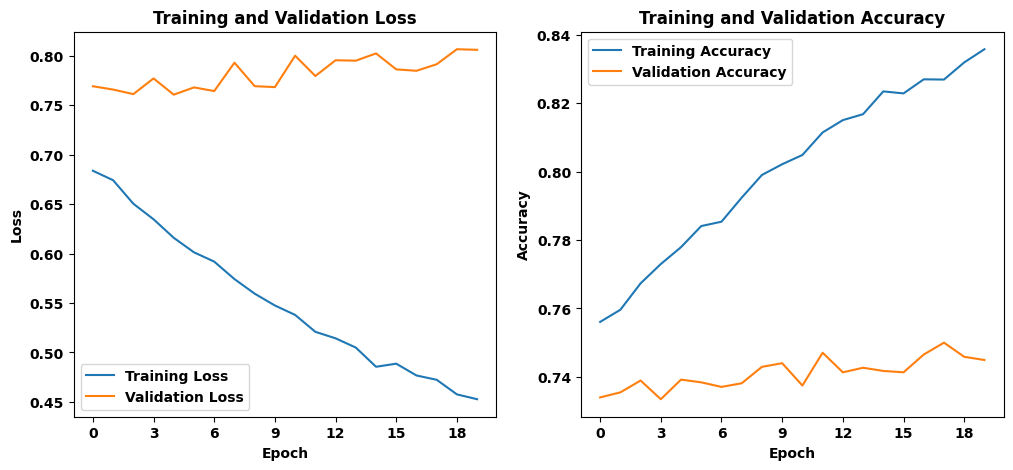

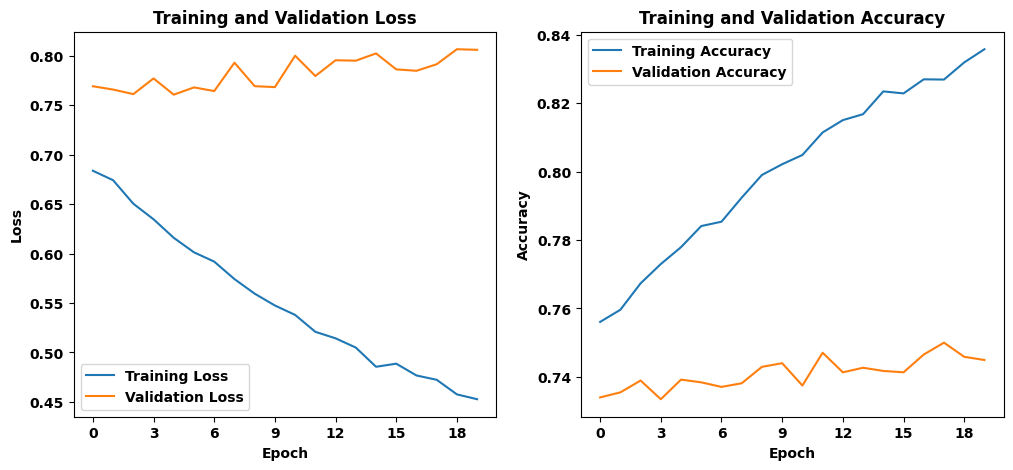

In [11]:
history_best_model = best_model.fit(
    X_train, y_train,
    epochs=20,  # You can adjust the number of epochs based on your requirement
    batch_size=64,
    verbose=2,
    validation_data=(X_validate, y_validate)
)

plot_losses(history_best_model)

In [15]:
best_model.save('../model/cnn_tuned_tf213.keras')
best_model.save('model/cnn_tuned_tf213.keras')

In [14]:
# evaluate accuracy
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {round(test_accuracy, 3)}")

# evaluate training time
evaluate_prediction_time(best_model, X_test)

313/313 [==============================] - 3s 11ms/step - loss: 0.8266 - accuracy: 0.7360
Test Accuracy: 0.736
4/4 [==============================] - 0s 10ms/step
Total time to predict 100 samples: 0.25 seconds
